In [1]:
# aim : predict earnings for foreign movies in the US
from bs4 import BeautifulSoup
import requests
import pandas as pd
import time
import scraping
import constants
import os
import numpy as np
import re
import seaborn as sns
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from seaborn import plt

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection  import KFold
from sklearn import preprocessing

import scipy.stats as stats
import patsy
import statsmodels.api as sm
%matplotlib inline

In [2]:
df = pd.read_csv('data/data_salary.csv', index_col=0)

# Adjust for inflation


In [3]:
with open ('data/inflation_multiplier.pkl', 'rb') as fp:
    inflation_mult = pickle.load(fp)

In [4]:
df['inflation'] = df['draft_year'].map(inflation_mult)

In [5]:
df['adjusted_salary'] = df['inflation'] * df['salary']

In [6]:
df.birthday = pd.to_datetime(df.birthday)

In [7]:
df['month'] = df.birthday.dt.month

In [8]:
def basic_plot(x_col, y_col, df, ax, x_label=None, y_label=None):
    if not x_label:
        x_label = x_col 
    if not y_label:
        y_label = y_col
    ax.scatter(df[x_col], df[y_col], label=y_label)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title('{} vs. {}'.format(x_label, y_label))
    

In [9]:
df = df.dropna()

In [10]:
df.columns

Index(['ast', 'ast_per_g', 'blk', 'college', 'draft_rank', 'draft_year',
       'end_age', 'fg', 'fg3', 'fg3_pct', 'fg3a', 'fg_pct', 'fga', 'ft',
       'ft_pct', 'fta', 'g', 'height_in', 'mp', 'mp_per_g', 'name',
       'name_index', 'no_of_seasons', 'per', 'pts', 'pts_per_g', 'reach_in',
       'start_age', 'stl', 'trb_per_g', 'weight_lb', 'wingspan_in', 'salary',
       'position', 'birthday', 'shoot', 'inflation', 'adjusted_salary',
       'month'],
      dtype='object')

In [11]:
df['log_salary'] = np.log(df.adjusted_salary)

# Regularization

In [12]:
# The numerical columns
x_columns = ['ast', 'ast_per_g', 'blk', 'draft_rank', 'draft_year',
       'end_age', 'fg', 'fg3', 'fg3_pct', 'fg3a', 'fg_pct', 'fga', 'ft',
       'ft_pct', 'fta', 'g', 'height_in', 'mp', 'mp_per_g',
       'no_of_seasons', 'pts', 'pts_per_g', 'reach_in',
       'stl', 'trb_per_g', 'weight_lb', 'wingspan_in']
# need to add shoot and position
def preprocess(df, cols = None, intercept=False, y_val='adjusted_salary'):
    if not cols:
        cols = x_columns
    y_data = df[y_val]
    X_data = df[cols]
    X_sc=preprocessing.normalize(X_data, axis=0, norm='max')
    # turn back in DF
    X_sc=pd.DataFrame(X_sc)
    X_sc.columns = cols
    X_data.columns = cols
    return X_sc, y_data, X_data

In [13]:
folds = 4
alpha_list=[1e-5,1e-3,1e-2, 1e-1,1, 10, 1e4]
def pick_alpha(fold, X, y, alphas=None):
    if not alphas:
        alphas = alpha_list
    kf = KFold(n_splits=fold)

    all_scores=[]


    for train, test in kf.split(X):
        x_train=X.iloc[train]
        y_train=y.iloc[train]
        x_test=X.iloc[test]
        y_test=y.iloc[test]
        mse_score=[]
        for a in alphas:
            est=Lasso(alpha=a)
            est.fit(x_train,y_train)
            mse=np.mean((y_test-est.predict(x_test))**2)
            mse_score.append(mse)
        all_scores.append(mse_score)
    plt.figure(figsize=(8,6))
    plt.legend()
    for i in range(fold):
        plt.plot(np.log10(alphas), all_scores[i],label = 'cv %s'%i)
    # Calculate the mean and plot it
    mean = np.array(all_scores).mean(axis=0).tolist()
    plt.plot(np.log10(alphas), mean, label = 'mean')
    plt.legend()
    plt.xlabel('alphas')
    plt.ylabel('MSE')
    plt.ylim(0)
    plt.show()

# First Iteration

/Users/josephinetirtanata/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/josephinetirtanata/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


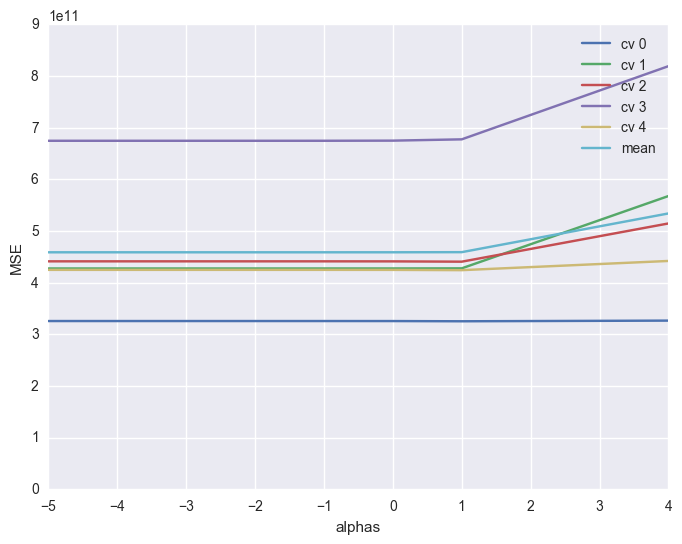

In [14]:
X_sc, y_data, X_data = preprocess(df)
pick_alpha(5, X_sc, y_data)

# Alpha
- It seems like 1 is the best value
- Now, let's take a look at the strongest features

In [15]:
# Take a quick look at our strongest features
def find_features(alpha, X, y, columns):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    est=Lasso(alpha=alpha)
    est.fit(X_train,y_train)
    zipped=zip(columns,est.coef_)
    features=sorted(zipped,key = lambda t: t[1],reverse=True)
    print(est.score(X_test, y_test))
    return [x for x in features if x[1] != 0] ,est
def print_summary (features, X, y):
    features = [x[0] for x in features]
    X_features = X[features]
    lsm = sm.OLS(y,X_features)
    fit = lsm.fit()
    fit.summary()


In [16]:
features,est = find_features(1, X_sc, y_data, X_sc.columns)

0.717352761499


/Users/josephinetirtanata/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [18]:
def print_coef(f, coef):
    zipped=zip(f,coef)
    features=sorted(zipped,key = lambda t: t[1],reverse=True)
    for (a,b) in features:
        print ('{}\t\t\t{}'.format(a,b))


# RCV

In [19]:
rcv = RidgeCV(cv=10)
f = [x[0] for x in features]
X_sc, y_data, X_data = preprocess(df, cols=f)
xtrain, xtest, ytrain, ytest = train_test_split(X_data, y_data, test_size=0.3)

rcv.fit(X_data, y_data)
rcv.score(xtest, ytest)


0.64841709160766614

In [20]:
rcv.intercept_

-51490882.920887545

In [21]:
print_coef(f, rcv.coef_)

fg_pct			141355.67312193473
ast_per_g			107725.76691645916
pts_per_g			67549.01834453136
trb_per_g			48877.31876028941
ft_pct			45080.480950595884
wingspan_in			30993.16400860038
draft_year			26730.44228314647
g			7158.545560853121
reach_in			3172.0502517726777
fg3			2749.6989353646786
weight_lb			900.9345546747891
blk			757.635156484668
pts			692.2465730509322
fta			119.63382337876888
ast			103.18585533020877
stl			82.80290092978673
mp			-22.81119513604885
fga			-265.3082687764228
fg3a			-1091.1591486550926
ft			-1135.7742602474602
fg			-2073.2929817493464
height_in			-13605.585847816592
fg3_pct			-22166.97194660926
mp_per_g			-25627.066417709
draft_rank			-48358.590234455914
no_of_seasons			-63428.643128676704
end_age			-102389.0776433975



## Scaled

In [24]:
rcv = RidgeCV(cv=10)
f = [x[0] for x in features]
xtrain, xtest, ytrain, ytest = train_test_split(X_sc, y_data, test_size=0.3)

rcv.fit(X_sc, y_data)
rcv.score(xtest, ytest)


0.66503210910329802

In [25]:
rcv.intercept_

-2500922.2373591634

In [26]:
print_coef(f, rcv.coef_)

draft_year			4944568.018313271
fg_pct			1787868.0464290483
g			1527725.506816751
wingspan_in			1220299.8537700002
pts_per_g			1112644.6677686695
fga			1065576.127252686
weight_lb			968302.4569785101
ast_per_g			941126.629640263
fta			838615.3972729179
ft_pct			769041.3355428991
fg3			764864.2313127151
trb_per_g			701095.0329226517
blk			557596.5554309606
fg3a			275009.83129733516
reach_in			-15913.107209603648
stl			-131555.5108786062
ast			-161532.7011621746
fg3_pct			-298801.06070272275
mp			-339658.3875517911
ft			-346011.7587752682
mp_per_g			-505888.44737814786
no_of_seasons			-1083826.4939536618
pts			-1315101.5748400881
height_in			-1386785.4712035637
fg			-1705580.8044677728
end_age			-2973587.818525251
draft_rank			-5079007.216799172


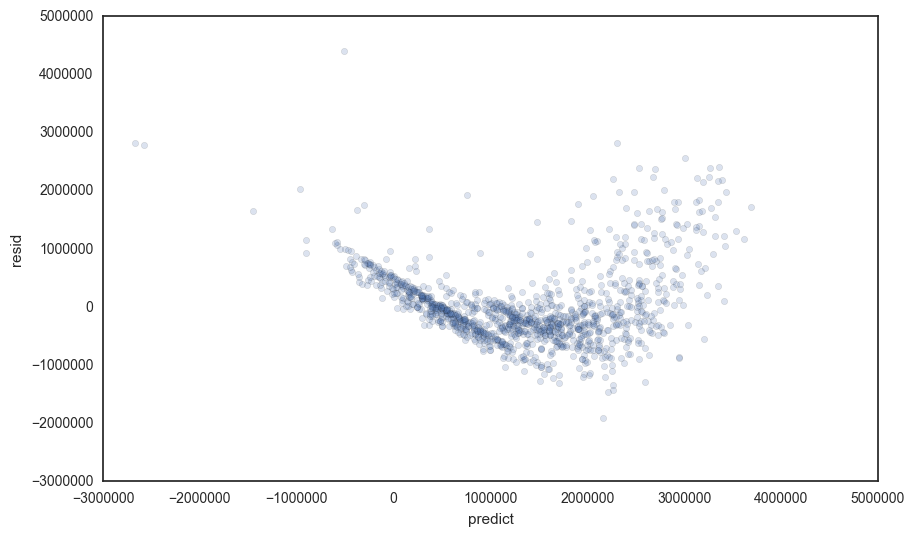

In [27]:
df['predict']=rcv.predict(X_sc)
df['resid']=df.adjusted_salary-df.predict
with sns.axes_style('white'):
    plot=df.plot(kind='scatter',
                  x='predict',y='resid',alpha=0.2,figsize=(10,6))

# Finding Multicollinearity

In [28]:
cor = X_data.corr()

In [29]:
for col in cor.columns:
    s = cor[col].sort_values(ascending=False)
    if (s.head(2).values[1] > 0.7):
        print(col, s.head(2).index[1], s.head(2).values[1])
    if (s.tail(1).values[0] < -0.7):
        print(col, s.tail(1).index[0], s.tail(1).values[0])

fga pts 0.975139163935
wingspan_in reach_in 0.935097654553
fg3 fg3a 0.989693348737
fta ft 0.969091489389
ast_per_g ast 0.843492347891
reach_in height_in 0.957784798043
g no_of_seasons 0.943331588335
weight_lb height_in 0.76086696746
stl ast 0.731073705151
mp g 0.773039626134
no_of_seasons g 0.943331588335
ast ast_per_g 0.843492347891
ft fta 0.969091489389
fg3a fg3 0.989693348737
height_in reach_in 0.957784798043
fg pts 0.980409943051
end_age no_of_seasons 0.705710514064
pts fg 0.980409943051


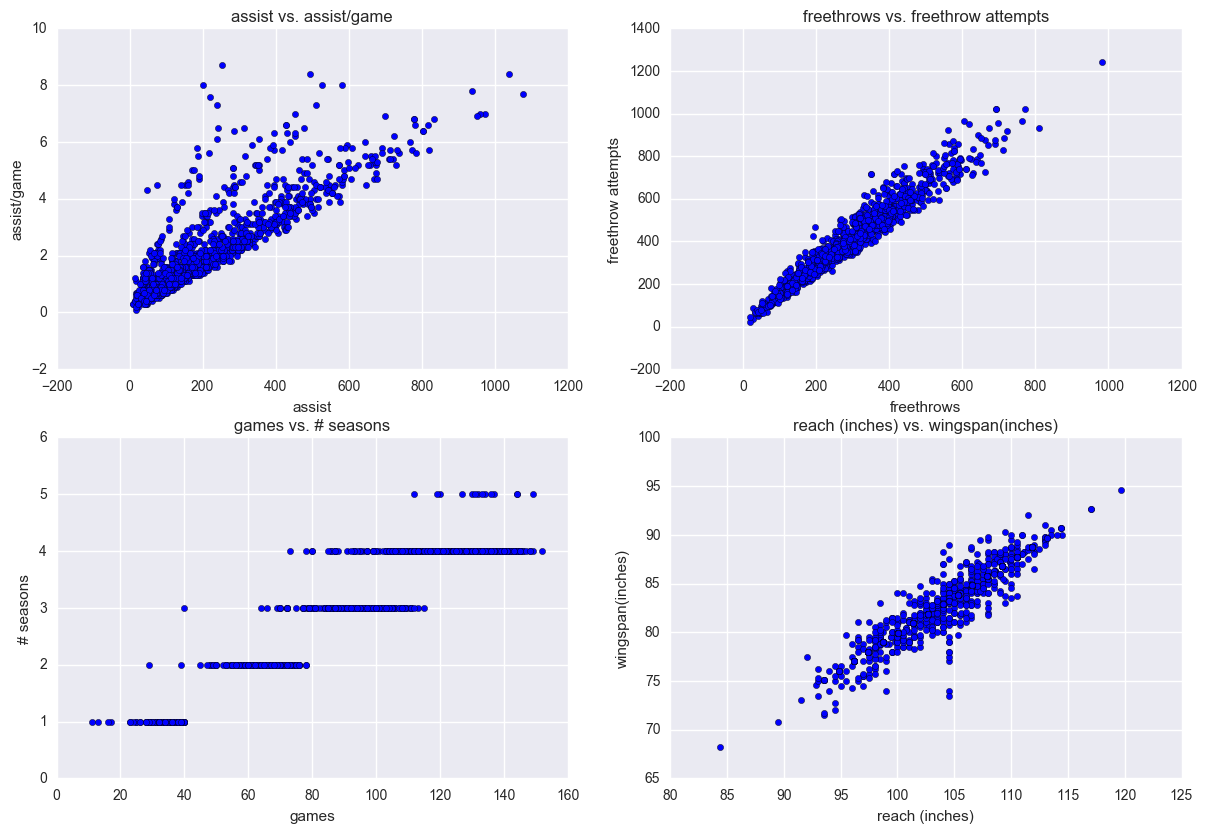

In [30]:
fig,ax = plt.subplots(2,2)
basic_plot('ast', 'ast_per_g', df, ax[0][0], 'assist', 'assist/game')
basic_plot('ft', 'fta', df, ax[0][1], 'freethrows', 'freethrow attempts')
basic_plot('g', 'no_of_seasons', df, ax[1][0],'games', '# seasons')
basic_plot('reach_in', 'wingspan_in', df, ax[1][1], 'reach (inches)', 'wingspan(inches)')
# basic_plot('mp', 'pts', df, ax[1][1])
fig.subplots_adjust(top=2, right=2)
# type(axes[0][1])

# Removing correlated values:
- pts and fg
- reach and height
- reach and wingspan
- pts and fga
- fg3 and fg3a
- ast_per_g and ast
- fta and ft
- g and no_of_seasons
- end_age and no_of_seasons
- stl and ast
- weight and height
- mp and pts

For some of these, it's pretty obvious which one to use. I will choose measures that suggest efficience vs an absolute no. (e.g. ast_per_g > ast)

## Removing:
- ast (over ast_per_g and stl)
- ft (over fta)
- no_of_seasons (over g and end_age)
- reach, wingspan, weight (over height) 
- mp (over pts)


In [31]:
rcv = RidgeCV(cv=10)
f = set([x[0] for x in features]) - set(['mp','fg3a','pts', 'fg','fga','reach_in','weight_lb', 'wingspan_in', 'no_of_seasons', 'ft', 'ast'])
f = list(f)
cor = df[f].corr()
for col in cor.columns:
    s = cor[col].sort_values(ascending=False)
    if (s.head(2).values[1] > 0.7):
        print(col, s.head(2).index[1], s.head(2).values[1])
    if (s.tail(1).values[0] < -0.7):
        print(col, s.tail(1).index[0], s.tail(1).values[0])
# make sure nothing is printed out

In [32]:
X_sc, y_data, X_data = preprocess(df, cols=f)
xtrain, xtest, ytrain, ytest = train_test_split(X_data, y_data, test_size=0.3)

rcv.fit(X_data, y_data)
rcv.score(xtest, ytest)

0.6667325295256068

In [33]:
mse = ((rcv.predict(xtest) - ytest)**2).mean()

In [34]:
mse

433030688786.72723

In [35]:
print_coef(f, rcv.coef_)

fg_pct			233097.72226940483
ast_per_g			119730.05754499185
fg3_pct			85538.00515611967
trb_per_g			57930.41844896303
ft_pct			43615.808272764654
pts_per_g			28921.734402764087
draft_year			28870.255423647814
height_in			14917.58419567235
blk			954.0360840034834
fg3			549.2234024710435
fta			-268.77274427946264
stl			-331.74280058439984
g			-654.3020658896514
mp_per_g			-31221.56861943063
draft_rank			-48717.919985529494
end_age			-101239.94308616301


In [36]:
rcv.intercept_


-54400770.126521327

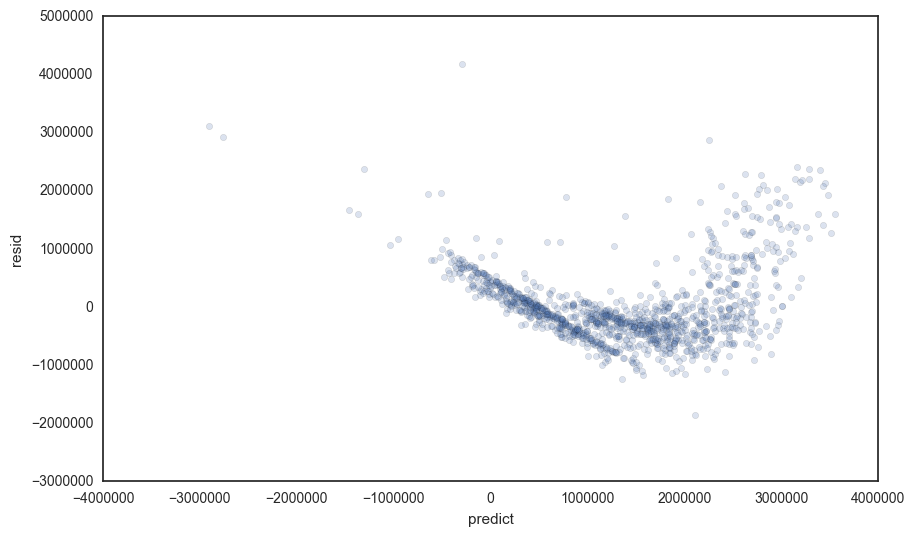

In [37]:
df['predict']=rcv.predict(X_data)
df['resid']=df.adjusted_salary-df.predict
with sns.axes_style('white'):
    plot=df.plot(kind='scatter',
                  x='predict',y='resid',alpha=0.2,figsize=(10,6))

In [38]:
# Confidence intervals
df['resid'].std() * 2

1290933.5721654228

In [39]:
rcv = RidgeCV(cv=10)
xtrain, xtest, ytrain, ytest = train_test_split(X_sc, y_data, test_size=0.3)

rcv.fit(X_sc, y_data)
rcv.score(xtest, ytest)

0.63985911129265738

In [40]:
rcv.intercept_



-2133747.9642682085

In [41]:
mse = ((rcv.predict(xtest) - ytest)**2).mean()
mse

438471901650.8938

In [42]:
mse**0.5

662172.1087835804

In [43]:
print_coef(f, rcv.coef_)

draft_year			6997600.824167108
fg_pct			1272901.3118542854
fg3			1025412.3812872819
trb_per_g			907101.2397742971
ast_per_g			840555.4524807456
blk			610778.1762241112
ft_pct			573964.0888328579
fta			70051.84598051674
height_in			-210647.91406922945
stl			-315082.8726435054
pts_per_g			-413034.2016655152
fg3_pct			-513148.2795136432
g			-646438.074175252
mp_per_g			-788886.7025781361
end_age			-3448817.193404936
draft_rank			-5079370.012970152


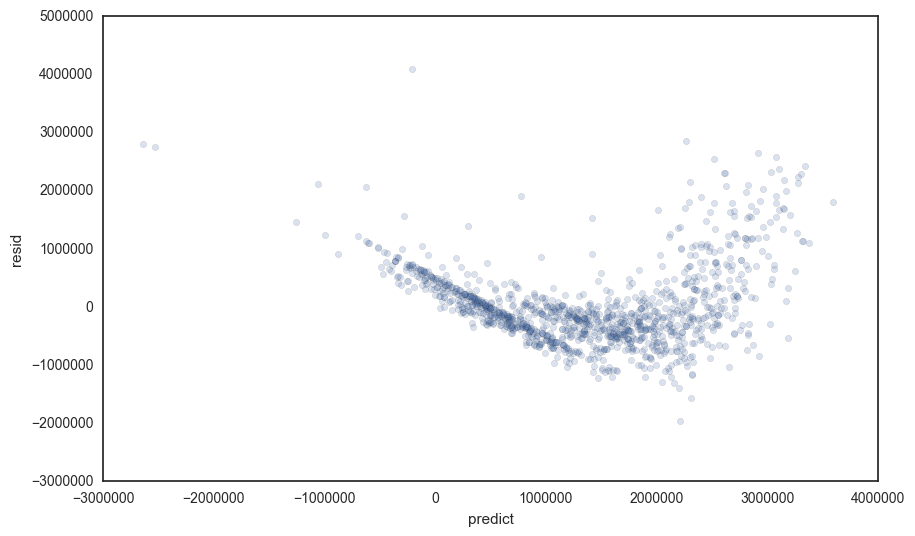

In [44]:
df['predict']=rcv.predict(X_sc)
df['resid']=df.adjusted_salary-df.predict
with sns.axes_style('white'):
    plot=df.plot(kind='scatter',
                  x='predict',y='resid',alpha=0.2,figsize=(10,6))

In [45]:
df['resid'].std()

665973.7764679486

In [46]:
def diagnostic_plot(x, y,label):
    s = len(x)
    plt.figure(figsize=(20,5))
    
    rgr = RidgeCV(cv=10)
    rgr.fit(x.reshape(s,1),y)
    pred = rgr.predict(x.reshape(s,1))

    plt.subplot(1, 3, 1)
    plt.scatter(x,y)
    plt.plot(x, pred, color='blue',linewidth=1)
    plt.title("Regression fit")
    plt.xlabel("x")
    plt.ylabel(label)
    
    plt.subplot(1, 3, 2)
    res = y - pred
    plt.scatter(pred, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")

In [48]:
df.loc[df.position.str.contains('Center'), 'center'] = 1
df.loc[~df.position.str.contains('Center'), 'center'] = 0
df.loc[df.position.str.contains('Guard'), 'guard'] = 1
df.loc[~df.position.str.contains('Guard'), 'guard'] = 0
df.loc[df.position.str.contains('Forward'), 'forward'] = 1
df.loc[~df.position.str.contains('Forward'), 'forward'] = 0

In [49]:
new_cols = x_columns + ['center', 'forward', 'guard']

In [50]:
new_cols = list(set(new_cols) - set(['start_age', 'month', 'end_age']))

/Users/josephinetirtanata/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/josephinetirtanata/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


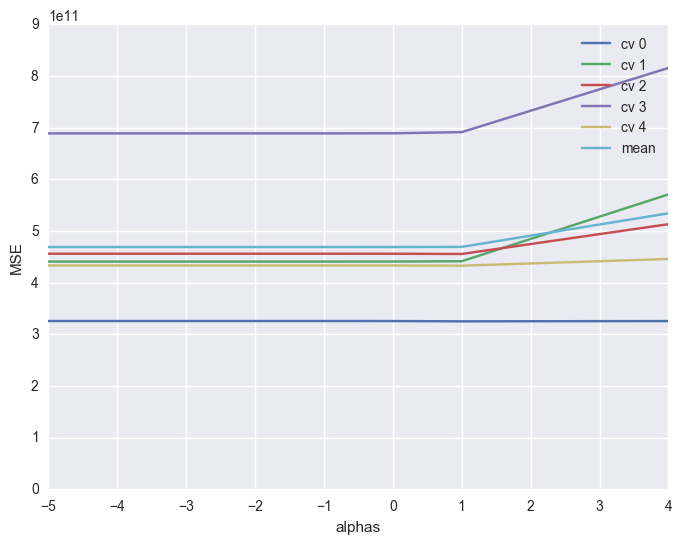

In [51]:
X_sc, y_data, X_data = preprocess(df, cols=new_cols)
pick_alpha(5, X_sc, y_data)

In [52]:
features, est = find_features(-1, X_sc, y_data, new_cols)

0.664575706314


/Users/josephinetirtanata/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [53]:
f = [x[0] for x in features]
X_sc, y_data, X_data = preprocess(df, f)
rcv = RidgeCV(cv=10)
xtrain, xtest, ytrain, ytest = train_test_split(X_sc, y_data, test_size=0.3)

rcv.fit(X_sc, y_data)
rcv.score(xtest, ytest)

0.64883581134448853

In [54]:
rcv.intercept_

856085.0484887769

In [55]:
print_coef(f, rcv.coef_)

fg_pct			905931.2767846462
g			864647.8461918976
weight_lb			859072.6019603547
draft_year			628394.4176461044
blk			596532.8449999787
ast_per_g			592935.9017268295
trb_per_g			568024.7243946804
pts_per_g			544860.7462556185
fg3a			542026.7592849693
ft_pct			494111.2774437264
fg3			468500.0754256203
fta			306957.5237118482
wingspan_in			194459.32696366563
ast			182698.48959497278
ft			109556.55785522358
forward			30912.50877436497
center			-2847.5064007617184
guard			-40892.727883786676
reach_in			-41033.32959018982
stl			-161956.23520381152
fg3_pct			-268228.34466886
mp_per_g			-294725.20680228376
mp			-305856.30023921083
height_in			-335658.57714557427
fga			-370138.1249710744
pts			-374907.58869007946
fg			-614162.2325021528
no_of_seasons			-1383001.901335781
draft_rank			-5071047.348826075


/Users/josephinetirtanata/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/josephinetirtanata/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


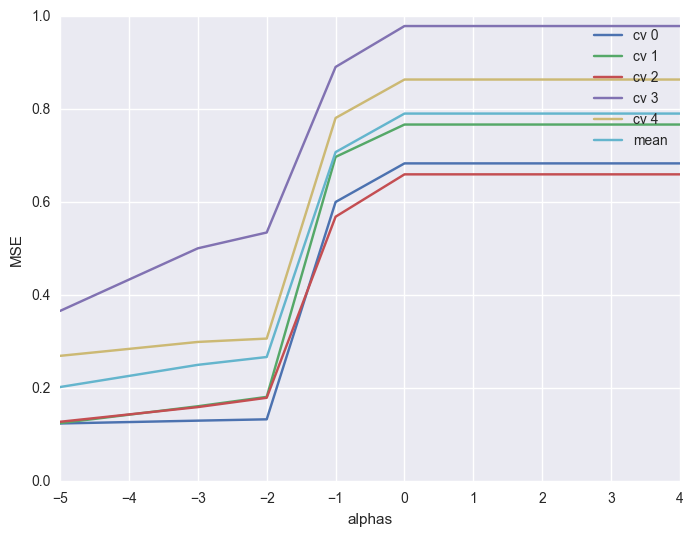

In [56]:

f = [x[0] for x in features]
f = f.extend(['center', 'forward', 'guard'])
X_sc, y_data, X_data = preprocess(df,cols=f, y_val='log_salary')
pick_alpha(5, X_sc, y_data)

In [57]:
features, est = find_features(1e-2, X_sc, y_data, X_data.columns)

0.647974920157


In [58]:
features

[('no_of_seasons', -0.42474421852115685), ('draft_rank', -4.1857992891212987)]

In [59]:
f = [x[0] for x in features]
X_sc, y_data, X_data = preprocess(df, f)
rcv = RidgeCV(cv=10)
xtrain, xtest, ytrain, ytest = train_test_split(X_data, y_data, test_size=0.3)

rcv.fit(X_data, y_data)
rcv.score(xtest, ytest)

0.63785788580809899

In [71]:
df[df.shoot=='switch']['name']

558    Tristan Thompson
Name: name, dtype: object